## Librerias

In [103]:
import pandas as pd
import numpy as np
import comtypes.client
import sys
import matplotlib.pyplot as plt
import os
import math
import openpyxl
from docx import Document
from docx.shared import Pt
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.shared import Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH
from io import BytesIO
import base64


def connect_to_existing_etabs():
    
        helper = comtypes.client.CreateObject('ETABSv1.Helper');
        helper = helper.QueryInterface(comtypes.gen.ETABSv1.cHelper);

        try:
            myETABSObject = helper.GetObject("CSI.ETABS.API.ETABSObject");
            print("Conectado exitosamente")
        except (OSError,comtypes.COMError):
            print("Ha fallado.")
            sys.exit(-1);

        SapModel = myETABSObject.SapModel
        return SapModel,myETABSObject,helper;

SapModel, myETABSObject, helper = connect_to_existing_etabs()

# Ton_m_C = 12
tonf_m_C = 12
ret = SapModel.SetPresentUnits(tonf_m_C)


Conectado exitosamente


In [104]:
name_table = "Modal Participating Mass Ratios"
table = SapModel.DatabaseTables.GetTableForDisplayArray(name_table ,GroupName="")    
cols=table[2]
noOfRows=table[3]
vals=np.array_split(table[4],noOfRows)
df= pd.DataFrame(vals)
df.columns=cols
df
# ELIMINAR COLUMNAS
columnas_a_eliminar = ['Case', 'UZ', 'SumUZ','RX','RY','SumRX','SumRY']
df = df.drop(columnas_a_eliminar, axis=1)
# RENOMBRAR COLUMNAS
nuevos_nombres = ['Modo', 'Periodo', 'UX','UY','SumUX','SumUY','RZ','SumRZ']
df.columns = nuevos_nombres

df

,Modo,Periodo,UX,UY,SumUX,SumUY,RZ,SumRZ
0,1,0.421,0.9201,0,0.9201,0,0,0
1,2,0.399,0,0.9227,0.9201,0.9227,0,0
2,3,0.353,0,0,0.9201,0.9227,0.9297,0.9297
3,4,0.135,0.0671,0,0.9872,0.9227,0,0.9297
4,5,0.128,0,0.0663,0.9872,0.9891,0,0.9297
5,6,0.113,0,0,0.9872,0.9891,0.0588,0.9886
6,7,0.076,0.0102,0,0.9974,0.9891,0,0.9886
7,8,0.072,0,0.0088,0.9974,0.9979,0,0.9886
8,9,0.065,0,0,0.9974,0.9979,0.0092,0.9978
9,10,0.053,0.0022,0,0.9996,0.9979,0,0.9978


In [105]:
# Crear un nuevo documento de Word
doc = Document()

# Definir un estilo de fuente personalizado para el título
#title_style = doc.styles.add_style('TitleStyle', WD_PARAGRAPH_ALIGNMENT.CENTER)
#title_format = title_style.font



# Título centrado
title = doc.add_heading('Análisis sísmico de edificio de 5 niveles', level=1)
title_format = title.runs[0].font
title_format.size = Pt(20)
title_format.bold = True
title.alignment = WD_PARAGRAPH_ALIGNMENT.CENTER

#title.style = title_style


# Agregar un párrafo vacío para crear un espacio entre el título y el subtítulo
doc.add_paragraph('')  # Esto agrega un párrafo vacío

# Texto de ejemplo
#example_text = doc.add_paragraph('Se presenta el edificio a analizar en la figura 1. Este edificio será analizado mediante un análisis modal espectral, no lineal estático y no lineal tiempo historia. Se presentarán los resultados más importantes para cada tipo de análisis.')
#example_text = doc.add_paragraph(
   # 'Se presenta el edificio a analizar en la figura 1. '
   # 'Este edificio será analizado mediante un análisis modal espectral, '
   # 'no lineal estático y no lineal tiempo historia. '
   # 'Se presentarán los resultados más importantes para cada tipo de análisis.'
#)

# Crear un párrafo para el texto
paragraph = doc.add_paragraph()
# Agregar el texto fragmento por fragmento con diferentes formatos
paragraph.add_run('Se presenta el edificio a analizar en la figura 1. ')#.bold = True
paragraph.add_run('Este edificio será analizado mediante un análisis modal espectral, ')#.italic = True
paragraph.add_run('no lineal estático y no lineal tiempo historia. ')
paragraph.add_run('Se presentarán los resultados más importantes para cada tipo de análisis.')

paragraph.alignment = 3  # 3 significa justificado
paragraph.paragraph_format.line_spacing = 1.5

#----------------------------------------------------------------------------------------
# Agregar un párrafo vacío para crear un espacio entre el título y el subtítulo
doc.add_paragraph('')  # Esto agrega un párrafo vacío

# Agregar imagen a WORD
doc.add_picture('3DPLANTA.png', width=Inches(6), height=Inches(3.5))
# Centrar imagen
last_paragraph = doc.paragraphs[-1] 
last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER


# Crear un título para la imagen
paragraph = doc.add_paragraph()
paragraph.add_run('Figura 1. ').bold = True
paragraph.add_run('Vista 3D y en planta del edificio a analizar.')#.bold = True
paragraph.alignment = 1  # 3 significa centrar

# -----------------------------------------------------------------------------------------


#example_text.alignment = 3  # 3 significa justificado
#example_text.paragraph_format.line_spacing = 1.5

# Subtítulo
subtitle = doc.add_heading('Análisis Modal Espectral', level=2)
subsubtitle = doc.add_heading('Modos de vibración', level=3)

# Crear un párrafo para el texto
paragraph = doc.add_paragraph()
# Agregar el texto fragmento por fragmento con diferentes formatos
paragraph.add_run('Se presenta en la tabla 1 los modos de vibración de la estructura analizada. ')#.bold = True

# --------------------------------------------------------------------------------------------------

# Crear un título para la TABLA
paragraph = doc.add_paragraph()
paragraph.add_run('Tabla 1. ').bold = True
paragraph.add_run('Modos de vibración para el edificio analizado.')#.bold = True
paragraph.alignment = 1  # 3 significa centrar

# Agregar una tabla al documento con 1 fila para los encabezados y n filas para los datos
table = doc.add_table(rows=df.shape[0] + 1, cols=len(df.columns))  # +1 para incluir la fila de encabezados

# Establecer estilos para la tabla y las celdas
table.style = 'Table Grid'  # Aplicar un estilo de tabla con líneas

# Agregar los encabezados de columna y centrar el texto
for i, column_name in enumerate(df.columns):
    cell = table.cell(0, i)
    cell.text = column_name
    for paragraph in cell.paragraphs:
        paragraph.alignment = 1  # 1 significa centrado

# Agregar los datos del DataFrame a la tabla y centrar el texto
for row in range(df.shape[0]):
    for col in range(df.shape[1]):
        cell = table.cell(row + 1, col)
        cell.text = str(df.iloc[row, col])
        for paragraph in cell.paragraphs:
            paragraph.alignment = 1  # 1 significa centrado


# --------------------------------------------------------------------------------------------------

subsubtitle = doc.add_heading('Desplazamientos máximos por nivel', level=3)
#----------------------------------------------------------------------------------------
# Agregar un párrafo vacío para crear un espacio entre el título y el subtítulo
doc.add_paragraph('')  # Esto agrega un párrafo vacío

# Agregar imagen a WORD
doc.add_picture('desplazamientos.png', width=Inches(3.5), height=Inches(5))
# Centrar imagen
last_paragraph = doc.paragraphs[-1] 
last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER


# Crear un título para la imagen
paragraph = doc.add_paragraph()
paragraph.add_run('Figura 2. ').bold = True
paragraph.add_run('Desplazamientos máximos por nivel.')#.bold = True
paragraph.alignment = 1  # 3 significa centrar

# -----------------------------------------------------------------------------------------

subsubtitle = doc.add_heading('Derivas máximas por nivel', level=3)


#----------------------------------------------------------------------------------------
# Agregar un párrafo vacío para crear un espacio entre el título y el subtítulo
doc.add_paragraph('')  # Esto agrega un párrafo vacío

# Agregar imagen a WORD
doc.add_picture('derivas.png', width=Inches(3.5), height=Inches(5))
# Centrar imagen
last_paragraph = doc.paragraphs[-1] 
last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER


# Crear un título para la imagen
paragraph = doc.add_paragraph()
paragraph.add_run('Figura 3. ').bold = True
paragraph.add_run('Derivas máximas por nivel.')#.bold = True
paragraph.alignment = 1  # 3 significa centrar

# -----------------------------------------------------------------------------------------

subsubtitle = doc.add_heading('Cortante máxima por nivel', level=3)

#----------------------------------------------------------------------------------------
# Agregar un párrafo vacío para crear un espacio entre el título y el subtítulo
doc.add_paragraph('')  # Esto agrega un párrafo vacío

# Agregar imagen a WORD
doc.add_picture('cortantes.png', width=Inches(3.5), height=Inches(5))
# Centrar imagen
last_paragraph = doc.paragraphs[-1] 
last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER


# Crear un título para la imagen
paragraph = doc.add_paragraph()
paragraph.add_run('Figura 4. ').bold = True
paragraph.add_run('Cortantes máximas por nivel.')#.bold = True
paragraph.alignment = 1  # 3 significa centrar

# -----------------------------------------------------------------------------------------

subsubtitle = doc.add_heading('Momento flector máximo en Viga', level=3)

#----------------------------------------------------------------------------------------
# Agregar un párrafo vacío para crear un espacio entre el título y el subtítulo
doc.add_paragraph('')  # Esto agrega un párrafo vacío

# Agregar imagen a WORD
doc.add_picture('viga.png', width=Inches(6), height=Inches(3.5))
# Centrar imagen
last_paragraph = doc.paragraphs[-1] 
last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER


# Crear un título para la imagen
paragraph = doc.add_paragraph()
paragraph.add_run('Figura 5. ').bold = True
paragraph.add_run('Momento máximo flector de viga.')#.bold = True
paragraph.alignment = 1  # 3 significa centrar

# -----------------------------------------------------------------------------------------


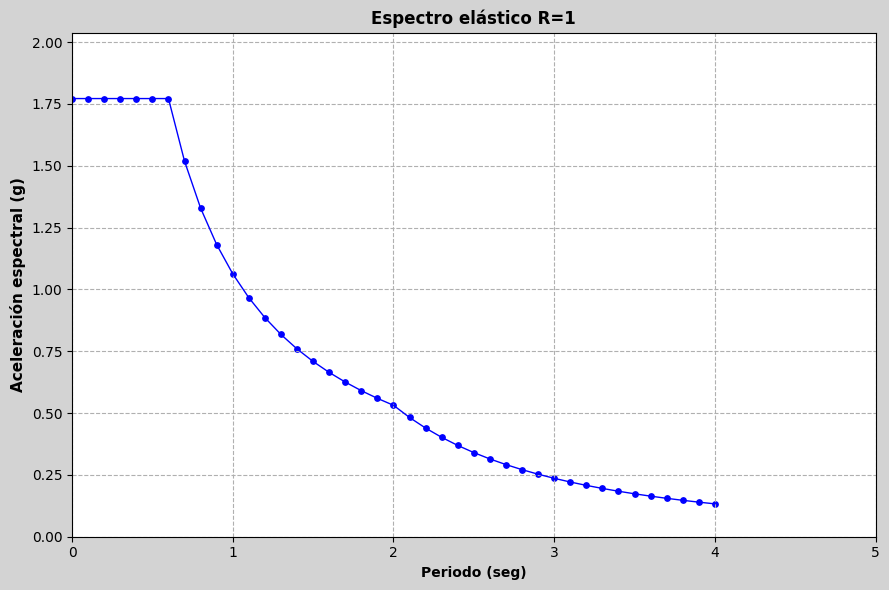

In [106]:
# Especifica la ruta de tu archivo Excel
ruta_excel = 'excelespectro.xlsx'

# Lee los datos desde el archivo Excel
datos = pd.read_excel(ruta_excel, sheet_name='Hoja2')

# Extrae la primera columna como una lista de strings y guárdala en "periodo"
periodo = datos.iloc[:, 0].astype(float).tolist()

# Extrae la segunda columna como una lista de strings y guárdala en "acc"
acc = datos.iloc[:, 1].astype(float).tolist()



# Crear el gráfico de dispersión con línea de conexión
#plt.figure(figsize=(6, 8))  # Tamaño del gráfico
plt.figure(figsize=(9, 6), facecolor='lightgray')  # Tamaño del gráfico y color de fondo gris
plt.scatter(periodo, acc, label='', marker='o', color='b', s=15)  # Puntos de dispersión
plt.plot(periodo, acc, label='', color='b', linewidth=1)  # Línea de conexión
plt.xlabel('Periodo (seg)', fontsize=10, fontweight='bold')  # Etiqueta del eje X
plt.ylabel('Aceleración espectral (g)', fontsize=11, fontweight='bold')  # Etiqueta del eje Y
plt.title('Espectro elástico R=1', fontsize=12, fontweight='bold')  # Título del gráfico

# Leyenda en la parte inferior derecha
#plt.legend(loc='lower right')

# Configuraciones adicionales para hacerlo más formal
plt.grid(True, linestyle='--')  # Cuadrícula con líneas punteadas
plt.tick_params(axis='both', which='major', labelsize=10)  # Tamaño de las etiquetas de los ejes
plt.xticks(rotation=0)  # Rotar etiquetas del eje X si es necesario
plt.xlim(0, max(periodo)*1.25)  # Establecer límites del eje X desde 0 hasta el valor máximo de desplazx
plt.ylim(0, max(acc)*1.15)  # Establecer límites del eje Y desde 0 hasta el valor máximo de niveles
plt.tight_layout()  # Ajustar el diseño

# Guardar el gráfico en un archivo (opcional)
plt.savefig('espectro.png', dpi=300)

# Mostrar el gráfico
plt.show()


In [107]:
# Subtítulo
subtitle = doc.add_heading('Análisis No Lineal Estático', level=2)
subsubtitle = doc.add_heading('Espectro elástico', level=3)

# Crear un párrafo para el texto
paragraph = doc.add_paragraph()
# Agregar el texto fragmento por fragmento con diferentes formatos
paragraph.add_run('Se calcula el desempeño del análisis no lineal estático y del no lineal tiempo historia ')#.bold = True
paragraph.add_run('en función del espectro elástico que se mostrará acontinuación. ')#.italic = True

# Función para convertir una ecuación LaTeX en una imagen PNG
def latex_to_image(latex):
    fig, ax = plt.subplots(figsize=(7, 0.55))
    ax.text(0.4, 0.4, f'${latex}$', size=10, ha='center', va='center')
    ax.axis('off')
    buffer = BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight', pad_inches=0.0, dpi=300)
    buffer.seek(0)
    image_data = base64.b64encode(buffer.read()).decode()
    plt.close()
    return image_data

### ---------------------------------------------------------------------------------------

# Agregar una ecuación LaTeX al documento

latex_equation = r'S_a(g) = Z \cdot U \cdot C \cdot S'  # Tu ecuación LaTeX aquí

# Convertir la ecuación LaTeX en una imagen
equation_image_data = latex_to_image(latex_equation)

# Insertar la imagen en el documento
doc.add_paragraph().add_run().add_picture(BytesIO(base64.b64decode(equation_image_data)))

# Centrar imagen
last_paragraph = doc.paragraphs[-1] 
last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER

### ---------------------------------------------------------------------------------------



#----------------------------------------------------------------------------------------
# Agregar un párrafo vacío para crear un espacio entre el título y el subtítulo
doc.add_paragraph('')  # Esto agrega un párrafo vacío

# Agregar imagen a WORD
doc.add_picture('espectro.png', width=Inches(6), height=Inches(3))
# Centrar imagen
last_paragraph = doc.paragraphs[-1] 
last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER


# Crear un título para la imagen
paragraph = doc.add_paragraph()
paragraph.add_run('Figura 6. ').bold = True
paragraph.add_run('Espectro elástico R=1.')#.bold = True
paragraph.alignment = 1  # 3 significa centrar

# -----------------------------------------------------------------------------------------





subsubtitle = doc.add_heading('Curva de capacidad', level=3)
#----------------------------------------------------------------------------------------
# Agregar un párrafo vacío para crear un espacio entre el título y el subtítulo
doc.add_paragraph('')  # Esto agrega un párrafo vacío

# Agregar imagen a WORD
doc.add_picture('curvacapacidadxx.png', width=Inches(6), height=Inches(3.5))
# Centrar imagen
last_paragraph = doc.paragraphs[-1] 
last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER


# Crear un título para la imagen
paragraph = doc.add_paragraph()
paragraph.add_run('Figura 7. ').bold = True
paragraph.add_run('Curva de capacidad en la dirección XX.')#.bold = True
paragraph.alignment = 1  # 3 significa centrar

# -----------------------------------------------------------------------------------------




# Subtítulo
subtitle = doc.add_heading('Análisis No Lineal Tiempo-Historia', level=2)
subsubtitle = doc.add_heading('Respuesta en el tiempo de desplazamiento', level=3)

#----------------------------------------------------------------------------------------
# Agregar un párrafo vacío para crear un espacio entre el título y el subtítulo
doc.add_paragraph('')  # Esto agrega un párrafo vacío

# Agregar imagen a WORD
doc.add_picture('desplaztiempo.png', width=Inches(6), height=Inches(3))
# Centrar imagen
last_paragraph = doc.paragraphs[-1] 
last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER


# Crear un título para la imagen
paragraph = doc.add_paragraph()
paragraph.add_run('Figura 8. ').bold = True
paragraph.add_run('Desplazamiento en el tiempo para Sismo Tacna 2010.')#.bold = True
paragraph.alignment = 1  # 3 significa centrar

# -----------------------------------------------------------------------------------------

subsubtitle = doc.add_heading('Respuesta en el tiempo de cortante basal', level=3)

#----------------------------------------------------------------------------------------
# Agregar un párrafo vacío para crear un espacio entre el título y el subtítulo
doc.add_paragraph('')  # Esto agrega un párrafo vacío

# Agregar imagen a WORD
doc.add_picture('fuerzatiempo.png', width=Inches(6), height=Inches(3))
# Centrar imagen
last_paragraph = doc.paragraphs[-1] 
last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER


# Crear un título para la imagen
paragraph = doc.add_paragraph()
paragraph.add_run('Figura 9. ').bold = True
paragraph.add_run('Cortante basal en el tiempo para sismo Tacna 2010.')#.bold = True
paragraph.alignment = 1  # 3 significa centrar

# -----------------------------------------------------------------------------------------


# Establecer el estilo de fuente para el subtítulo
subtitle_format = subtitle.runs[0].font
subtitle_format.size = Pt(14)
subtitle_format.bold = True

# Subsubtítulo (nivel 3) con formato personalizado
subsubtitle_format = subsubtitle.runs[0].font
subsubtitle_format.size = Pt(12)
subsubtitle_format.italic = True



# Texto en negrita
#bold_text = doc.add_paragraph('Este es un ejemplo de texto en negrita.')
#bold_text.runs[0].bold = True



# Guardar el documento en un archivo
doc.save('documento_ejemplo.docx')

print('Documento creado exitosamente.')

Documento creado exitosamente.
